In [1]:
import PIL
import tkinter
import cv2

In [2]:
import tkinter as Tk

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import path
import cv2


import pandas as pd



from skimage import io
from skimage import transform
#from skimage import segmentation
from skimage import filters
#from skimage import morphology
from skimage import measure
from skimage import util

from sklearn import cluster

from scipy.spatial import ConvexHull

In [4]:
from ipywidgets import interactive
import ipywidgets as widgets

import numpy as np
from matplotlib import pyplot as plt

from skimage import io
from skimage import util
from skimage import filters
from skimage import morphology
from skimage import measure
from skimage import exposure

from sklearn import cluster

import os

In [5]:
from tkinter import *
from PIL import Image
from PIL import ImageTk


In [6]:
import tkinter.filedialog


In [7]:
farmWidth = 3.0 # meters
tubenetPerMeter = 10 # meters
scale = 1.0

initSigma = 1
offset = -0.05
finalSigma = 1
min_samples = 5

sigma=1.0
block_size=41
min_size=128
eps=10
percentile_range = [80,100]

In [8]:
def read(imgFile,invert=False):
    img = io.imread(imgFile,as_gray=True)
    img = util.img_as_float(img)
    if invert:
        img = util.invert(img)    
    
    img_x, img_y = img.shape
    return img

def readRGB(imgFile):
    rgbimg = io.imread(imgFile)
    return rgbimg

def rescale(img,scale):
    if img is not None:
        scale = np.float(scale)
        img_rs = transform.rescale(img,scale,multichannel=False)
        return img_rs
    
def plotImg(img,title=None,cmap='gray',figsize=(15,15)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.axis('off')
    ax.imshow(img,cmap=cmap)
    if title:
        ax.set_title(title,fontsize=20)
    plt.show()
    
    
def init_thresh(img):
    img_g = filters.gaussian(img,sigma=sigma)

    img_g_thresh = filters.threshold_local(img_g,block_size=block_size)

    img_g_applyThresh = (img_g-img_g_thresh)

    img_g_applyThresh = exposure.rescale_intensity(img_g_applyThresh)
    
    return(img_g_applyThresh)

def apply_iso(img_g_applyThresh):

    img_g_applyThresh_iso = filters.threshold_isodata(img_g_applyThresh)
    img_areas = (img_g_applyThresh<img_g_applyThresh_iso)
    
    return(img_areas)

def apply_clrclo(img_areas, min_size):
    img_clr = morphology.remove_small_objects(img_areas,min_size=min_size,connectivity=2)
    img_clo = morphology.remove_small_holes(img_clr,area_threshold=2048,connectivity=2)
    coords = np.asarray(np.where(img_clo == True)).T
    return(coords)

def applyDBSCAN(coords,eps=10, min_samples=5):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(coords)
    predictions = dbscan.labels_
    return predictions



def applyConvexHull_Groups(coords,groups):
    
    groupNums_overall = np.unique(groups)
    groupNums_subset = []
    
    groupCoords = []
    groupHulls = []
    #img_rs_groups = []
    groupVertices = []
    #groupAreas = [ ]
    #groupVolumes = [ ]
    
    for groupNum in groupNums_overall:
        
        thisCoords = []
        
        for i in range(len(coords)):
            if groups[i]==groupNum:
                thisCoords.append(coords[i])
        
        
        thisHull = ConvexHull(thisCoords)
        hull_area = thisHull.area
        
        if hull_area>=400:
            groupNums_subset.append(groupNum)
            groupCoords.append(np.array(thisCoords))
            groupHulls.append(thisHull)
            #groupAreas.append(thisHull.area)
            #groupVolumes.append(thisHull.volume)

            #thisImg = np.multiply(img, img_groups==groupNum)
            #img_rs_groups.append(thisImg)
        
            thisVertices = []
            for vertex in thisHull.vertices:
                thisVertices.append([thisCoords[vertex][1],thisCoords[vertex][0]])
            groupVertices.append(np.array(thisVertices))

    return groupCoords,groupHulls,groupVertices,groupNums_subset





def applyLabels_binImg(img,coords,labels):
    label_mask = np.zeros(img.shape).astype('uint')
    for i in range(len(coords)):
        row,col = coords[i]
        label_mask[row][col]=labels[i]
    return label_mask


def small_weeding(groupLabel_Mask):
    group_areas = [region.area for region in measure.regionprops(groupLabel_Mask)]
    new_coords = []
    new_groups = []
    
    #percentile_range = [80,100]
    
    #size_min = np.percentile(group_areas,percentile_range[0])
    #size_max = np.percentile(group_areas,percentile_range[1])

    #img_groupMask = np.zeros(img.shape).astype('float')
    #img_new_labelMask = np.zeros(img.shape).astype('uint')
    


    for region in measure.regionprops(groupLabel_Mask):
        if region.area>=400:        
            reg_coords = region.coords
            for elem1, elem2 in reg_coords:
                #img_groupMask[elem1, elem2] = True
                #img_new_labelMask[elem1, elem2] = groupLabel_Mask[elem1, elem2]
                new_coords.append([elem1, elem2])
                new_groups.append(groupLabel_Mask[elem1, elem2])
    
    new_coords = np.asarray(new_coords)
    new_groups = np.asarray(new_groups)
    
    return(new_coords, new_groups)

In [9]:
def plotRGBImg_GroupsRS(rgbimg,groupNums,groupVertices,scale, fmt='k-',linewidth=1,annotate=True):
    fig, ax = plt.subplots(1,1,figsize=(15, 15))
    ax.axis('off')
    ax.imshow(rgbimg)
    for i,groupNum in enumerate(groupNums):
        ax.fill(groupVertices[i][:,0]/scale,
                groupVertices[i][:,1]/scale,
                fmt,linewidth=linewidth,fill=False)
        
        
        length = groupVertices[i].shape[0]
        sum_x = np.sum(groupVertices[i][:, 0])
        sum_y = np.sum(groupVertices[i][:, 1])
        
        if annotate:
            ax.annotate(int(i+1),xy=(sum_x/(length*scale), (sum_y)/(length * scale)), color='gold', size = 13)
        
    #filename = 'hull'+str(index_ext)+'.png'
    #path = '/Users/praneeth/Downloads/Image Processing/Srideep_to_Praneeth_files/Bigger_basket/hull/'+filename
    #plt.savefig(path)
    


def plotRGBImg_GroupsRS_rectangle(rgbimg,groupNums,groupVertices,scale, fmt='k-',linewidth=1,annotate=True):
    color = (0, 0, 0)
    thickness = 2
    
    for i,groupNum in enumerate(groupNums):
        x,y,w,h = cv2.boundingRect(groupVertices[i])        
        rgbimg = cv2.rectangle(rgbimg,(x,y),(x+w,y+h),color,thickness)
     
    fig, ax = plt.subplots(1,1,figsize=(15, 15))
    ax.axis('off')
    ax.imshow(rgbimg)

    for i in range(len(groupNums)):
        x,y,w,h = cv2.boundingRect(groupVertices[i])        
        if annotate:
            ax.annotate(int(i+1),xy=(int(x + (w/4)), int(y + (h/2))),  color='gold', size = 13)
    
    #filename = 'rectangle'+str(index_ext)+'.png'
    #path = '/Users/praneeth/Downloads/Image Processing/Srideep_to_Praneeth_files/Bigger_basket/rectangle/'+filename
    #plt.savefig(path)


    
def plotRGBImg_GroupsRS_rotated_rectangle(rgbimg,groupNums,groupVertices, scale, fmt='k-',linewidth=1, annotate=True):
    scale_map = float(3/45)


    area_overall = []
    
    #rotated_rect_coordinates = []
    #rotated_rect_areas =[]
    
    color = (0,0,0) 
    thickness = 2
    isClosed = True

    for i,groupNum in enumerate(groupNums):
                
        rect = cv2.minAreaRect(groupVertices[i])
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        rgbimg = cv2.drawContours(rgbimg,[box],0,color,thickness)        
        area_overall.append(cv2.contourArea(box))
        
        #rotated_rect_area_specific = rect[1][0] * rect[1][1]
        #rotated_rect_areas.append(rotated_rect_area_specific)
        #rotated_rect_coordinates.append([box])
    
    area_sq_metres= [np.round((area_overall[i]*scale_map*scale_map), 2) for i in range(len(area_overall))]
    sum_area_sq_metres = np.round(sum(area_sq_metres), 2)
    title_text = "Total area of the tilted rectangles is "+ str(sum_area_sq_metres) + " sq. metres"


    
    fig, ax = plt.subplots(1,1,figsize=(15, 15))
    #fig.suptitle(title_text, fontsize=20)

    
    ax.set_title(title_text, fontsize=20)
    ax.axis('off')
    ax.imshow(rgbimg)


    for i in range(len(groupNums)):
        length = groupVertices[i].shape[0]
        sum_x = np.sum(groupVertices[i][:, 0])
        sum_y = np.sum(groupVertices[i][:, 1])

        if annotate:
            ax.annotate(int(i+1),xy=(sum_x/(length*scale), sum_y/(length * scale)), color='gold', size = 13)
    
    
    
    save_path = '/Users/praneeth/Downloads/Image Processing/Updates_in_Sep2020/temp/rotated_rectangle.png'
    plt.savefig(save_path)
    
    
    return(area_sq_metres)

In [10]:
folder = '/Users/praneeth/Downloads/Image Processing/Updates_in_Sep2020/images_from_video/'
filename = 'DRONE_TRANSECT_AR_16SEP19 23.png'

In [11]:
def select_image():
    # grab a reference to the image panels
    global panelA, panelB
    # open a file chooser dialog and allow the user to select an input
    # image
    path = tkinter.filedialog.askopenfilename()

    if len(path) > 0:
        # load the image from disk, convert it to grayscale, and detect
        # edges in it
        #image = cv2.imread(path)
        #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #edged = cv2.Canny(gray, 50, 100)
        # OpenCV represents images in BGR order; however PIL represents
        # images in RGB order, so we need to swap the channels
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # convert the images to PIL format...
        #image = Image.fromarray(image)
        #edged = Image.fromarray(edged)
        # ...and then to ImageTk format
        #image = ImageTk.PhotoImage(image)
        #edged = ImageTk.PhotoImage(edged)
        
        
        imgFile = path
        img = read(imgFile)
        imgrgb = readRGB(imgFile)

        img_g_applyThresh = init_thresh(img)
        img_areas = apply_iso(img_g_applyThresh)
        coords = apply_clrclo(img_areas, min_size)
        groups = applyDBSCAN(coords, eps=eps, min_samples=min_samples)
        groupLabel_Mask = applyLabels_binImg(img,coords,groups)
        new_coords,new_groups = small_weeding(groupLabel_Mask)
        groupCoords,groupHulls,groupVertices, groupNums_subset = applyConvexHull_Groups(new_coords,new_groups)
        groupNums = np.asarray(groupNums_subset, 'uint64')

        imgrgb_rot_rect= imgrgb.copy()
        area_sq_metres= plotRGBImg_GroupsRS_rotated_rectangle(imgrgb_rot_rect,groupNums,groupVertices, scale, annotate=True)
        
        
        big_image = cv2.imread(path)
        big_image = cv2.cvtColor(big_image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(big_image, (0,0), fx=0.15, fy=0.15) 

        
        
        save_path = '/Users/praneeth/Downloads/Image Processing/Updates_in_Sep2020/temp/rotated_rectangle.png'
        big_edged = cv2.imread(save_path)
        big_edged = cv2.cvtColor(big_edged, cv2.COLOR_BGR2RGB)
        edged = cv2.resize(big_edged,(0,0), fx=0.7, fy=0.7) 
        
        # convert the images to PIL format...
        image = Image.fromarray(image)
        edged = Image.fromarray(edged)
        # ...and then to ImageTk format
        image = ImageTk.PhotoImage(image)
        edged = ImageTk.PhotoImage(edged)

        
        
    #if the panels are None, initialize them
    if panelA is None or panelB is None:
        # the first panel will store our original image
        panelA = Label(image=image)
        panelA.image = image
        panelA.pack(side="left", padx=10, pady=10)
        # while the second panel will store the edge map
        panelB = Label(image=edged)
        panelB.image = edged
        panelB.pack(side="right", padx=10, pady=10)
        # otherwise, update the image panels
    else:
        # update the pannels
        panelA.configure(image=image)
        panelB.configure(image=edged)
        panelA.image = image
        panelB.image = edged
    

In [12]:
#import tkinter as tk
#root = tk.Tk()


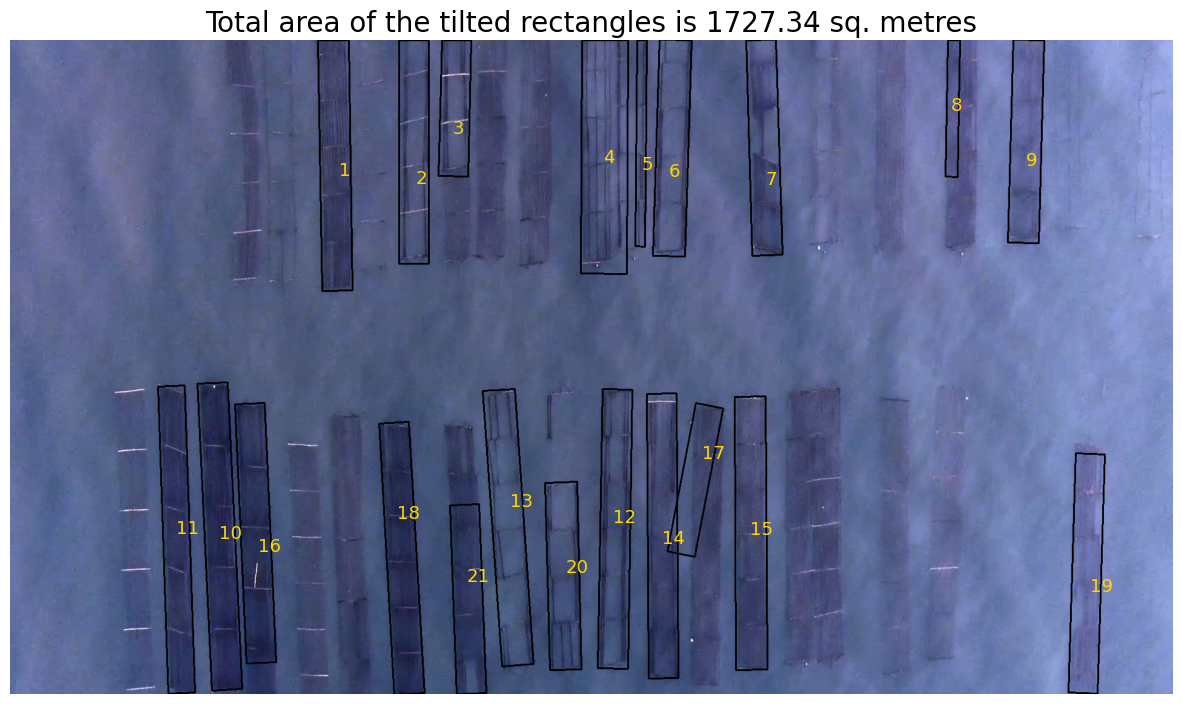

In [13]:
root = Tk()
panelA = None
panelB = None
# create a button, then when pressed, will trigger a file chooser
# dialog and allow the user to select an input image; then add the
# button the GUI
btn = Button(root, text="Select an image", command=select_image)
btn.pack(side="bottom", fill="both", expand="yes", padx="10", pady="10")
# kick off the GUI
root.mainloop()
